In [212]:
from zipfile import ZipFile

from PIL import Image, ImageDraw, ImageFont
import pytesseract
import cv2 as cv
import numpy as np
import imp
import math

# loading the face detection classifier
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe" ## path to tesseract

In [213]:
def extract_faces_from_photo(image_dict, scale=1.3, minNeighbors=5):
    '''
    Function that extracts faces from image
        scale and minNeighbours are params for detectMultiscale method
    '''
    detection_classifier = imp.find_module('cv2')[1] + '\data\haarcascade_frontalface_default.xml'
    face_cascade = cv.CascadeClassifier(detection_classifier)
    
    cv_image = cv.imread(image_dict['image_name'])
    gray = cv.cvtColor(cv_image, cv.COLOR_BGR2GRAY)
    text = pytesseract.image_to_string(image=gray)
    faces = face_cascade.detectMultiScale(gray, scale, minNeighbors)
    
    #drawing=ImageDraw.Draw(image_dict['image_pil'])
    page_faces = []
    for face in faces:
        x1, y1, x2, y2 = face[0], face[1], face[0] + face[2], face[1] + face[3]
        rec = [x1, y1, x2, y2]
        #drawing.rectangle(rec, outline='white')
        cropped_image = image_dict['image_pil'].crop(rec)
        page_faces.append(cropped_image)
    return page_faces

In [214]:
def find_string_with_faces(file_names, searched_word):
    '''
    Determine if the word is on the page for every element in file_names
        file_names - list of all files that should be checked
        searched_word - string 
    '''
    images = []
    for image_name in file_names:
        image = Image.open(image_name)
        gray_image = image.convert('1')
        text = pytesseract.image_to_string(image=gray_image)
        if searched_word in text:
            image_dict = {'image_name': image_name, 'image_pil': image}
            page_faces = extract_faces_from_photo(image_dict)
            image_dict['faces'] = page_faces
            images.append(image_dict)
    return images

In [215]:
 def create_title_for_image(text='Hello', no_faces=False):
    '''
    Create a photo answer
        no_faces - boolean value that determine if faces are existed
        if not we add another sign to title
    '''
    text_image_size = (550, 35)
    txt = Image.new("RGB", text_image_size, (255,255,255))
    font = ImageFont.truetype("arial.ttf", 15)
    d = ImageDraw.Draw(txt)
    d.text((10,0), text, font=font, fill=(0,0,0))
    if no_faces:
        d.text((10, 17), 'But there were no faces in that file', font=font, fill=(0,0,0))
    return txt

In [216]:
def create_photo_collage(images):
    '''
    Combine all extracted faces from one answer together
    '''
    photo_image_size = (550, 110 * math.ceil(len(images)/5))
    photo_collage_background = Image.new('RGB', photo_image_size, (0,0,0))
    size_of_photo = (110, 110)
    width = 0
    height = 0
    for image in images:
        if image.size[0] > 110:
            new_image = image.resize((110, 110), Image.ANTIALIAS)
        else:
            new_image = image
        photo_collage_background.paste(new_image, (width, height))
        width += 110
        if width >= 550:
            height += 110
            width = 0
    return photo_collage_background

In [217]:
def combine_answers_together(result_images):
    '''
    This function combine all photos of faces together
        result_images - list of all images(titles and faces)
    '''
    final_result_list = [] 
    for res in result_images:
        if res['faces']:
            title = f'Results found in file {res["image_name"]}'
            final_result_list.append(create_title_for_image(title))
            final_result_list.append(create_photo_collage(res['faces']))
        else:
            final_result_list.append(create_title_for_image(res['image_name'], True))
    height = sum([x.size[1] for x in final_result_list])
    width = 550
    result_size = (width, height)
    final_photo = Image.new("RGB", result_size, (255,255,255))
    h = 0
    for res in final_result_list:
        final_photo.paste(res, (0, h))
        h += res.size[1]
    return final_photo

In [218]:
def show_the_answer(zip_file, searched_word='Mark'):
    '''
    It's a result function. 
        zip_file is a string parameter(path of zip file)
        searched_word is a word that should be found
    the answer is shown result photo
    '''
    with ZipFile(zip_file, 'r') as zip_file:
        file_names = zip_file.namelist()
        zip_file.extractall()
        
    result_images = find_string_with_faces(file_names, searched_word)
    final_photo = combine_answers_together(result_images)
    display(final_photo)

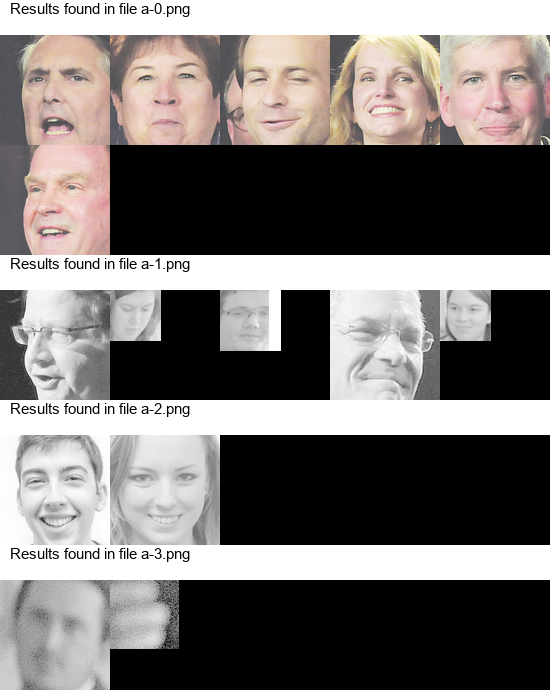

In [219]:
show_the_answer('small_img.zip')